In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, chirp2total, total2chirp, match_h1_h2, get_h, match_s_f_max

In [2]:
sample_rate = 4096

# e^2 against chirp mass plot functions

In [3]:
# Calculates matches to a fiducial h1, h2 waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match(e_vals, chirp_vals, fiducials, f_low, approximant='TEOBResumS', max_method=None):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'h1':[], 'h1_phase':[], 'h2':[], 'h2_phase':[], 'diff_phase':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Generate fiducial waveform
    _, h1, h2, _, _ = get_h([1,1], f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant)

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['h1'].append([])
        matches['h1_phase'].append([])
        matches['h2'].append([])
        matches['h2_phase'].append([])
        matches['diff_phase'].append([])
        matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate h1, h2 matches
            if max_method == None:
                s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
                match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
            else:
                match_h1, match_h2 = match_s_f_max(h1, h2, f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant, max_method=max_method)

            # Save matches
            matches['h1'][-1].append(abs(match_h1))
            matches['h1_phase'][-1].append(np.angle(match_h1))
            matches['h2'][-1].append(abs(match_h2))
            matches['h2_phase'][-1].append(np.angle(match_h2))
            matches['diff_phase'][-1].append(np.angle(match_h1) - np.angle(match_h2))
            match_quad = np.sqrt(abs(match_h1)**2+abs(match_h2**2))
            matches['quad'][-1].append(match_quad)

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [4]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot(e_vals, chirp_vals, fiducials, matches, vmins=[0.7,0.7,0.7], vmaxs=[1,1,1], quiver=True):
    
    # Convert to eccentricity squared
    e2_vals = e_vals**2

    # Make contour plot for  each match
    for i, key in enumerate(['h1', 'h2', 'quad']):

        # Which direction colorbar extends
        if [vmins[i], vmaxs[i]] == [0,1]:
            extend = 'neither'
        elif vmins[i] == 0:
            extend = 'max'
        elif vmaxs[i] == 1:
            extend = 'min'
        else:
            extend = 'both'

        # Plotting amplitude contours
        plt.contourf(chirp_vals, e2_vals, matches[key], np.linspace(vmins[i], vmaxs[i], 15), vmin=vmins[i], vmax=vmaxs[i], extend=extend)
        plt.colorbar(label='match')
        plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

    # Make contour plot for phase of each match
    for i, key in enumerate(['h1_phase', 'h2_phase', 'diff_phase']):

        # phase
        plt.contourf(chirp_vals, e2_vals, matches[key], cmap='twilight_shifted')
        plt.colorbar(label='phase of complex overlap')
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

        # cos(phase)
        plt.contourf(chirp_vals, e2_vals, np.cos(matches[key]))
        plt.colorbar(label='cos(phase) of complex overlap')
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key} (cos), q={fiducials[2]}')
        plt.show()

# $e_{10}=0.1, \mathcal{M}=24~M_\odot, q=2$

## No maximisation over shifted frequencies (1 TEOB call per grid point)

In [5]:
e_vals_1 = np.linspace(0, 0.2, 31)
chirp_vals_1 = np.linspace(23, 25, 31)
start = time.time()
dataslot_1 = ecc_chirp_match(e_vals_1, chirp_vals_1, [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

961 done out of 961
Time taken: 1370.6742641925812 seconds


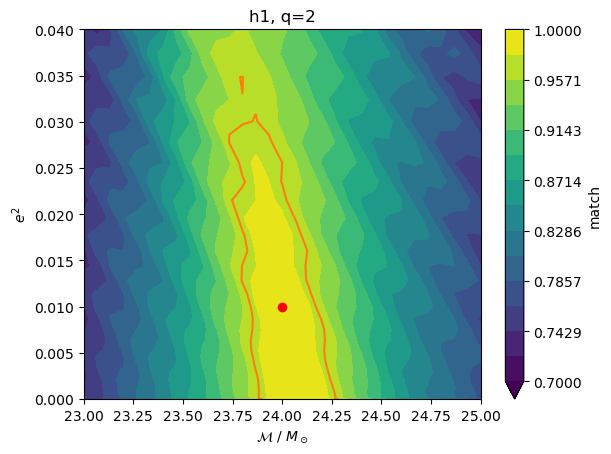

/local/ben.patterson/ipykernel_1174624/3728331228.py:23: UserWarning: No contour levels were found within the data range.
  plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])


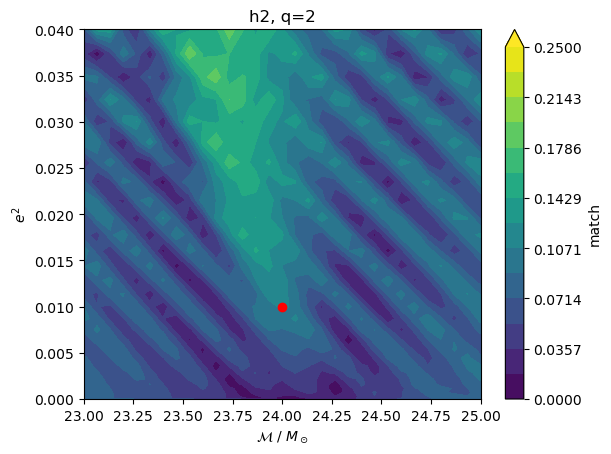

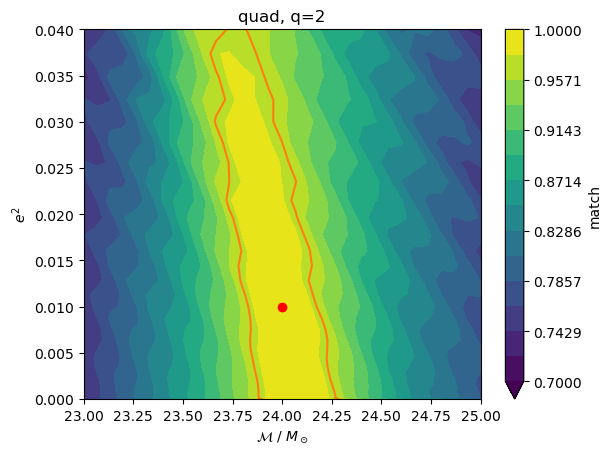

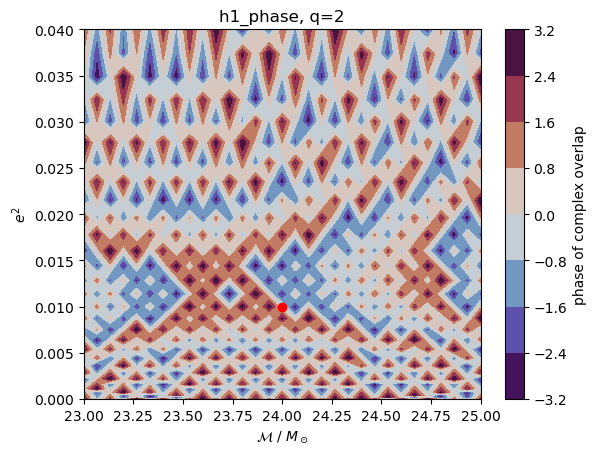

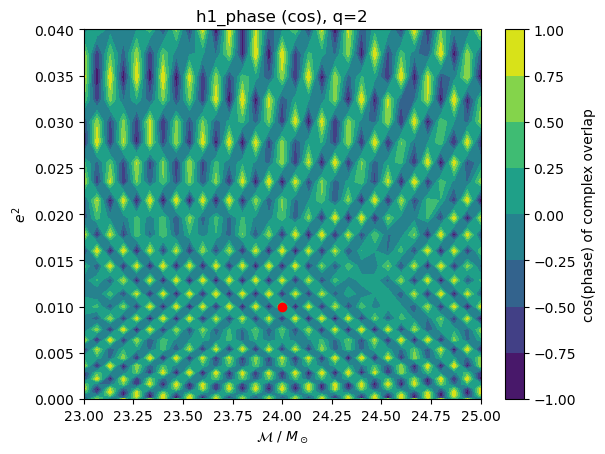

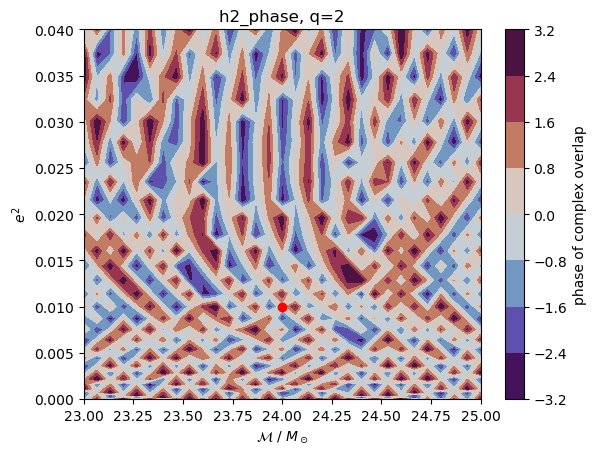

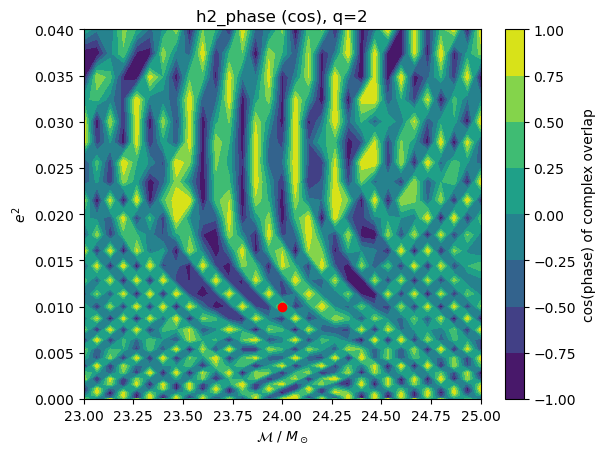

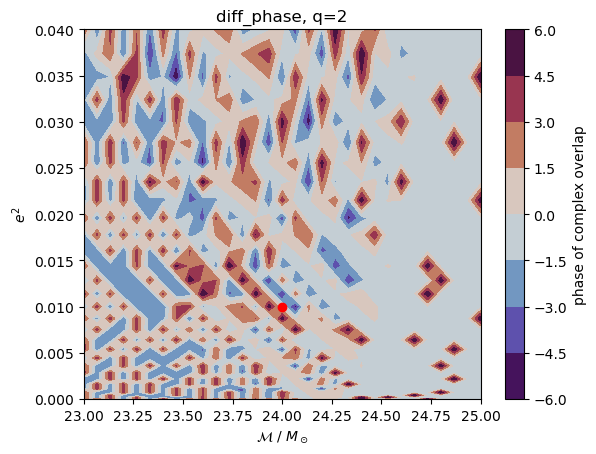

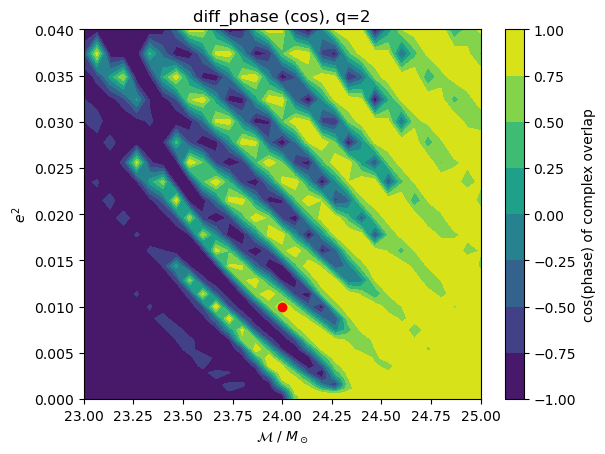

In [10]:
ecc_chirp_plot(e_vals_1, chirp_vals_1, [0.1, 24, 2], dataslot_1, vmins=[0.7,0,0.7], vmaxs=[1,0.25,1])

## Maximisation over shifted frequencies with the phase difference method (2 TEOB calls per grid point)

In [7]:
e_vals_2 = np.linspace(0, 0.2, 31)
chirp_vals_2 = np.linspace(23, 25, 31)
start = time.time()
dataslot_2 = ecc_chirp_match(e_vals_2, chirp_vals_2, [0.1, 24, 2], 10, max_method='phase_diff')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

961 done out of 961
Time taken: 2802.8171751499176 seconds


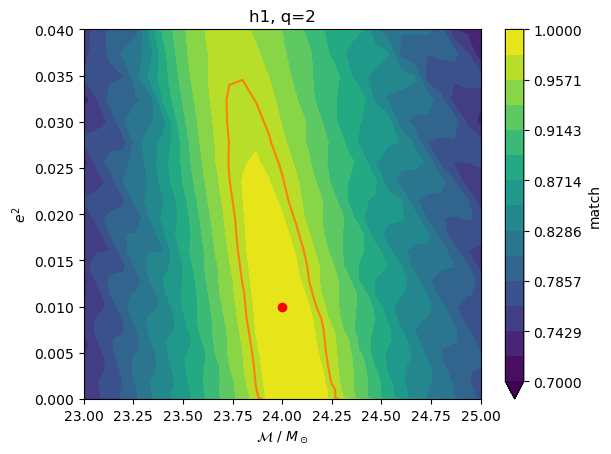

/local/ben.patterson/ipykernel_2154596/3728331228.py:23: UserWarning: No contour levels were found within the data range.
  plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])


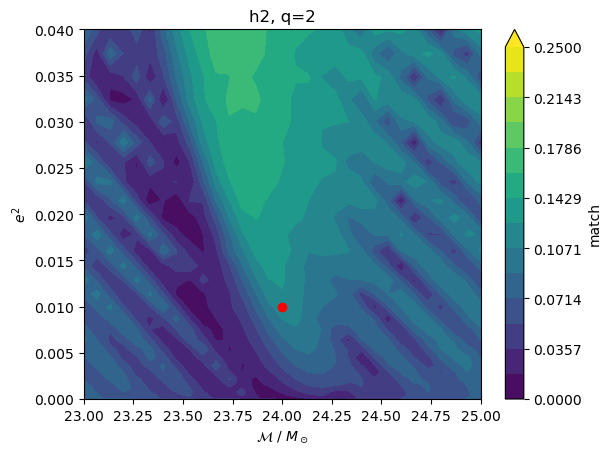

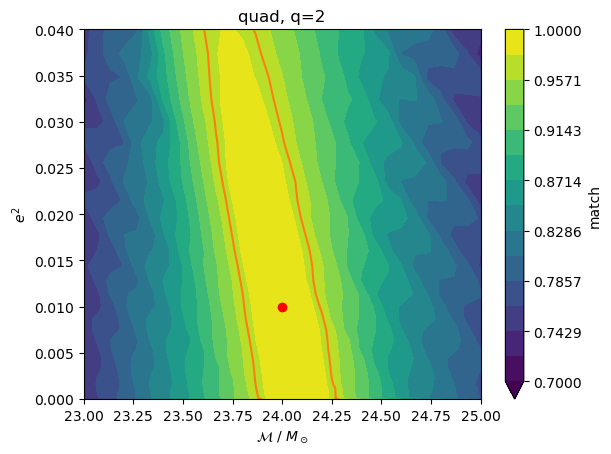

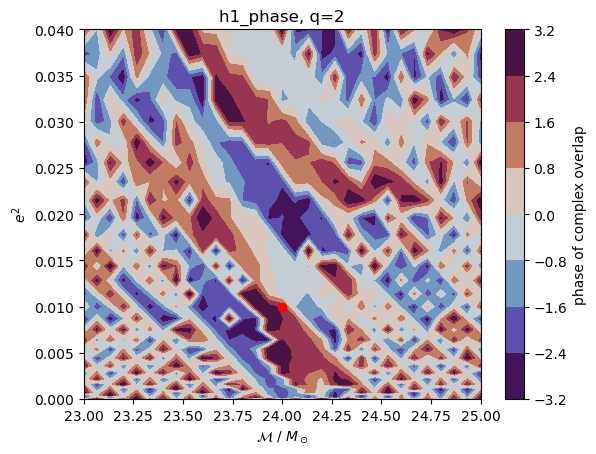

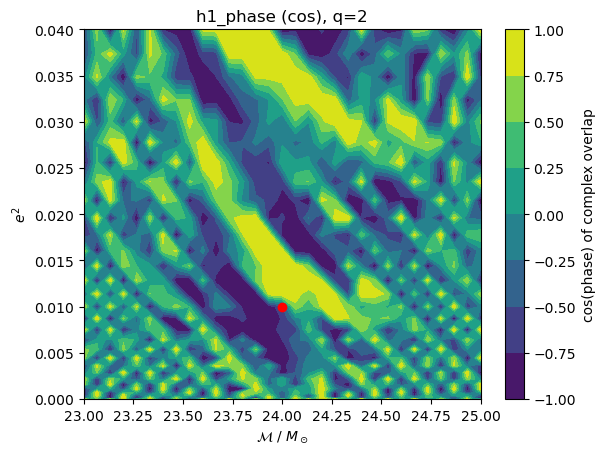

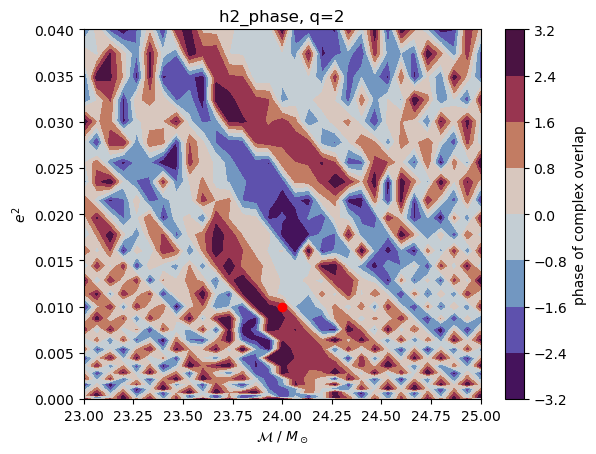

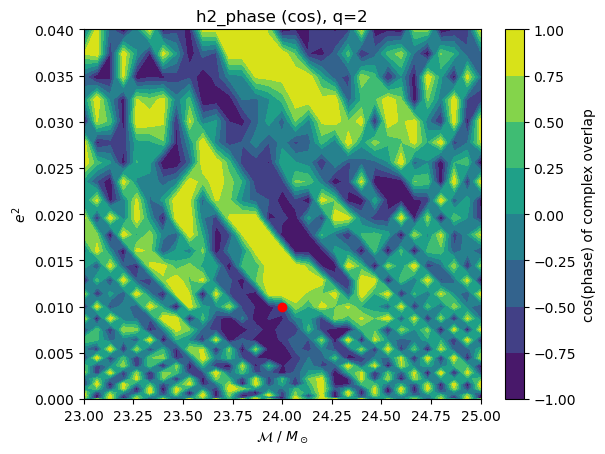

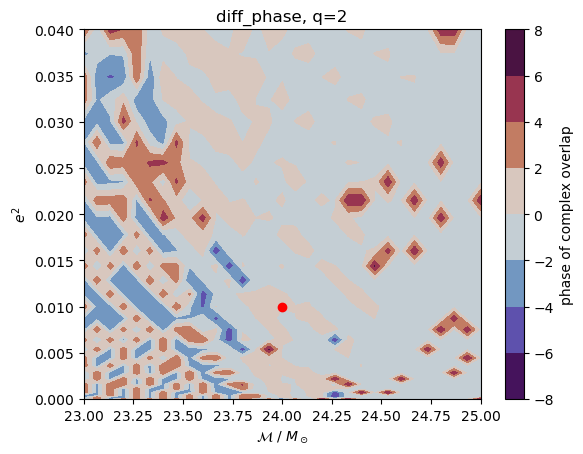

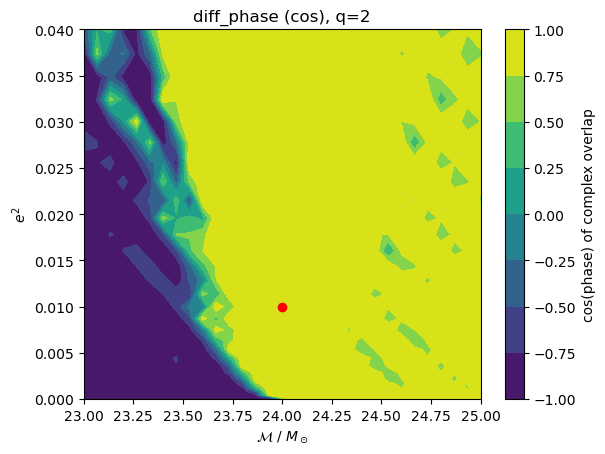

In [8]:
ecc_chirp_plot(e_vals_2, chirp_vals_2, [0.1, 24, 2], dataslot_2, vmins=[0.7,0,0.7], vmaxs=[1,0.25,1])